# HomeWork #6

Завдання 1 <br>
У цьому завданні вам потрібно завантажити ось цей датасет. Тут ви знайдете 2 файли - з двовимірним датасетом та датасетом mnist. Для кожного з них застосуйте алгоритм K-means для кластеризації. Щоб знайти оптимальну кількість кластерів, скористайтесь ліктєвим методом.<br><br>
Завдання 2<br>
Візуалізуйте результат роботи кластеризації. Для випадку з mnist датасетом, вам потрібно ще скористатись алгоримтом PCA щоб зменшити розмірність ваших даних до 2-вимірного варіанту.<br>

In [755]:
from pathlib import Path
import random
from typing import Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## OBTAIN

In [756]:
def read_from_csvfile(file: Path, header: Optional[str]='infer') -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file, header=header)
    
    return df

Читаємо всі датасети з файлів `csv` у папці `data`

In [757]:
dfs = [read_from_csvfile(item, None) for item in Path('data').iterdir() if item.is_file() and item.suffix.lower() in ('.csv',)]

Виділяємо різні набори

In [758]:
data_2d, mnist = dfs[0], dfs[1]

In [759]:
mnist.shape, data_2d.shape

((500, 785), (200, 3))

Так як зазначено що датасет `data_2d` двовимірний, - першу колонку вважатимемо позначенням приналежністю до кластерів.

In [760]:
data_2d.columns = ['y', 'x1', 'x2']

In [761]:
data_2d.head(3)

,y,x1,x2
0,0.0,-0.768716,0.460860
1,0.0,2.687848,2.366961
2,0.0,-0.201379,0.470430


Так як не зазначено нічого що вказує на те що перша колонка позначення приналежності до кластерів, то спершу вважатимемо що всі колонки даних - фічі (параметри), а в другому випадку приймемо, що перша колонка - позначення приналежності до класів (0-9)

In [762]:
mnist.columns = [f'x{el}' for el in range(mnist.shape[1])]

In [763]:
mnist.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Перевіримо чи є дублікати для першрго стовпця

In [764]:
not mnist['x0'].is_unique, mnist['x0'].min(), mnist['x0'].max()

(True, 0, 9)

Якщо перша колонка - кластери (позначення), то визначимо скільки значень у кожному

In [765]:
clusters = {}
[clusters.update({el:1}) if (clusters.get(el) is None) else clusters.update({el:clusters.get(el)+1}) for el in mnist['x0']]
clusters

{7: 49, 2: 55, 1: 67, 0: 42, 4: 55, 9: 54, 5: 50, 6: 43, 3: 45, 8: 40}

# `data_2d`

## SCRUB & EXPLORE

In [766]:
def draw_2D_scatter(as_x: list, as_y: list, mark: Optional[str], title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x)) / len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x)) / len(as_x))/10 or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y)) / len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y)) / len(as_y))/10 or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    plt.xticks(rotation=85)
    
    plt.scatter(as_x, as_y, c=mark, cmap='viridis')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    ax.grid(which='both')
    plt.show()

/tmp/ipykernel_4624/3806943738.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(as_x, as_y, c=mark, cmap='viridis')


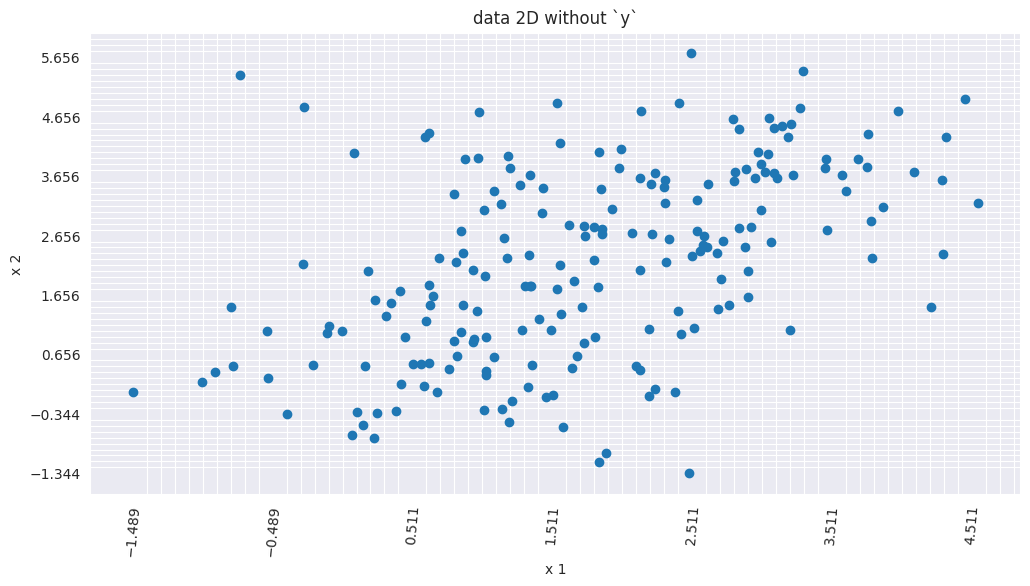

In [767]:
size = (12, 6)
draw_2D_scatter(as_x=data_2d['x1'], as_y=data_2d['x2'], mark=None, title=f'data 2D without `y`', xlabel='x 1', ylabel=f'x 2', figsize=size)

Як бачимо з меж, попередня нормалізація - зайва

## MODEL

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

##### Розрахуємо для розбиття на кластери від 1 до 11

In [768]:
X = data_2d[['x1', 'x2']].to_numpy()
x = [n_clus for n_clus in range(1, 12)]
kmeans = [KMeans(n_clusters=n_clus, random_state=0, n_init='auto').fit(X) for n_clus in x]

In [769]:
y = [km.inertia_ for km in kmeans]

In [770]:
def draw_2D(as_x: list, as_y: list, title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)/10) or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)/10) or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

    plt.plot(
             as_x, 
             as_y, 
            #  label=f'2D', 
             color=random.choice('rgbcmyk'), 
             linestyle=random.choice(['-', '--', '-.', ':', None]),
             marker=random.choice('o+xdvs*.^')
             )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    ax.grid(which='both')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


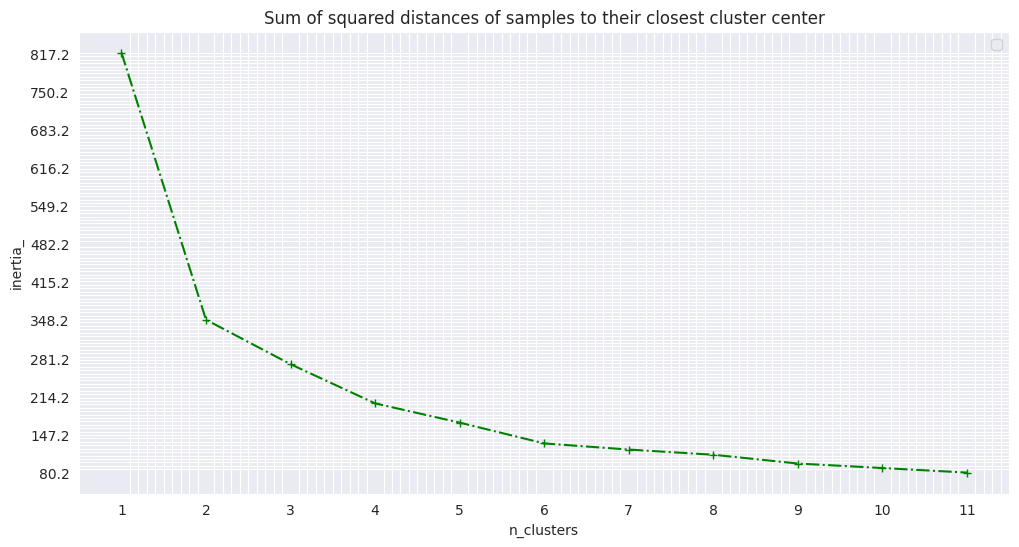

In [771]:
title = 'Sum of squared distances of samples to their closest cluster center'
draw_2D(as_x=x, as_y=y, title=title, xlabel='n_clusters', ylabel=f'inertia_', figsize=(12, 6))

Візуально начебто 2 кластери оптимально, але ...

- https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python
- https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
- https://github.com/arvkevi/kneed

In [772]:
kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')

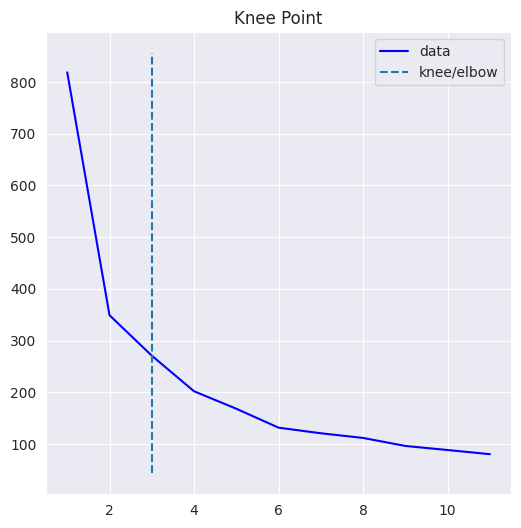

In [773]:
kneedle.plot_knee()

За алгоритмом оптимального значення: кластерів 3, зі значенням (суми) найбільших квадратичних відхилень від центроїдів 270.76

In [774]:
kneedle.knee, kneedle.knee_y

(3, 270.7630149091877)

Відносне зменшення значення найбільших квадратичних відхилень від центроїдів при покрокомому збільшенні кількості кластерів від 1

In [775]:
[(y[el-1]-y[el])/y[el-1] for el in range(len(y)) if el != 0]

[0.5737653082456687,
 0.2240980675924168,
 0.25441836710633886,
 0.1674350644425511,
 0.21781515371328108,
 0.08226000723630648,
 0.07506702535704798,
 0.13883175893527078,
 0.08200447518568267,
 0.0910162065603665]

In [776]:
kmeans[1:3]

[KMeans(n_clusters=2, n_init='auto', random_state=0),
 KMeans(n_clusters=3, n_init='auto', random_state=0)]

##### Якщо взяти з початкових даних перший стовпчик як результат кластеризації (відомий клас)

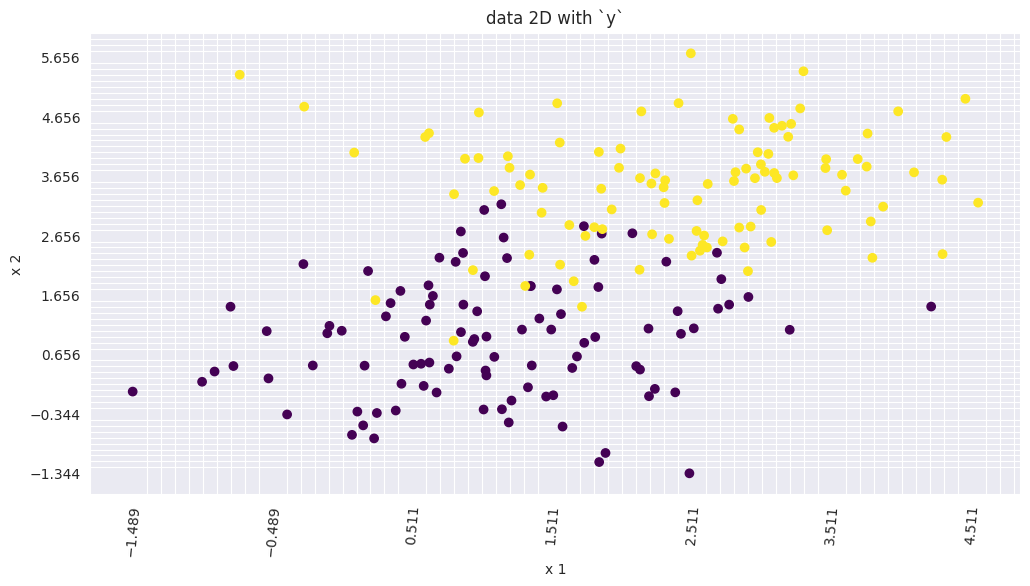

In [777]:
draw_2D_scatter(as_x=data_2d['x1'], as_y=data_2d['x2'], mark=data_2d['y'], title=f'data 2D with `y`', xlabel='x 1', ylabel=f'x 2', figsize=size)

##### Якщо взяти кластеризацію з розбиттям на 2 класи

In [778]:
kmeans[1].labels_

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0], dtype=int32)

In [779]:
kmeans[1].cluster_centers_

array([[2.46540572, 3.48660748],
       [0.97799508, 0.80217417]])

In [780]:
centroids = pd.DataFrame(kmeans[1].cluster_centers_)
centroids.columns = ['x1', 'x2']

In [781]:
centroids

,x1,x2
0,2.465406,3.486607
1,0.977995,0.802174


Додамо результат кластеризації - позначення `y2`

In [782]:
y2 = pd.DataFrame({'y2':kmeans[1].labels_})
data_2d_c = pd.concat([data_2d, y2], axis=1)
data_2d_c.head()

,y,x1,x2,y2
0,0.0,-0.768716,0.460860,1
1,0.0,2.687848,2.366961,0
2,0.0,-0.201379,0.470430,1
3,0.0,0.608496,1.225400,1
4,0.0,-0.082282,1.137218,1


Додамо центроїди

In [783]:
с2 = pd.DataFrame({'y2':[centroids.shape[0]+1, centroids.shape[0]+2]})
с2 = pd.concat([с2, centroids], axis=1)
с2.head()

,y2,x1,x2
0,3,2.465406,3.486607
1,4,0.977995,0.802174


In [784]:
data_2d_c = pd.concat([data_2d_c, с2], axis=0, ignore_index=True)
data_2d_c.tail(3)

,y,x1,x2,y2
199,1.0,3.764228,4.372587,0
200,NaN,2.465406,3.486607,3
201,NaN,0.977995,0.802174,4


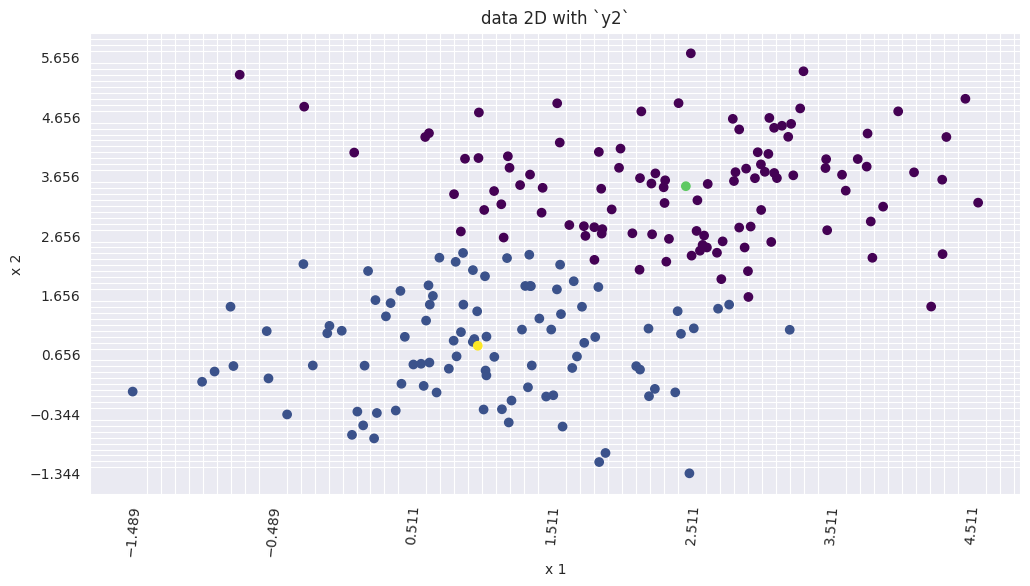

In [785]:
draw_2D_scatter(as_x=data_2d_c['x1'], as_y=data_2d_c['x2'], mark=data_2d_c['y2'], title=f'data 2D with `y2`', xlabel='x 1', ylabel=f'x 2', figsize=size)

##### Якщо взяти з кластеризацію з розбиттям на 3 класи

In [786]:
kmeans[2].labels_

array([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0], dtype=int32)

In [787]:
kmeans[2].cluster_centers_

array([[2.67513782, 3.99328211],
       [0.74771856, 0.50438896],
       [1.96916569, 2.32414269]])

In [788]:
centroids = pd.DataFrame(kmeans[2].cluster_centers_)
centroids.columns = ['x1', 'x2']

In [789]:
centroids

,x1,x2
0,2.675138,3.993282
1,0.747719,0.504389
2,1.969166,2.324143


Додамо результат кластеризації - позначення `y3` та центроїди

In [790]:
y3 = pd.DataFrame({'y3':kmeans[2].labels_})
data_2d_c = pd.concat([data_2d, y3], axis=1)
с3 = pd.DataFrame({'y3':[centroids.shape[0] + i for i in range(centroids.shape[0])], })
с3 = pd.concat([с3, centroids], axis=1)
data_2d_c = pd.concat([data_2d_c, с3], axis=0, ignore_index=True)
data_2d_c.tail(3)

,y,x1,x2,y3
200,NaN,2.675138,3.993282,3
201,NaN,0.747719,0.504389,4
202,NaN,1.969166,2.324143,5


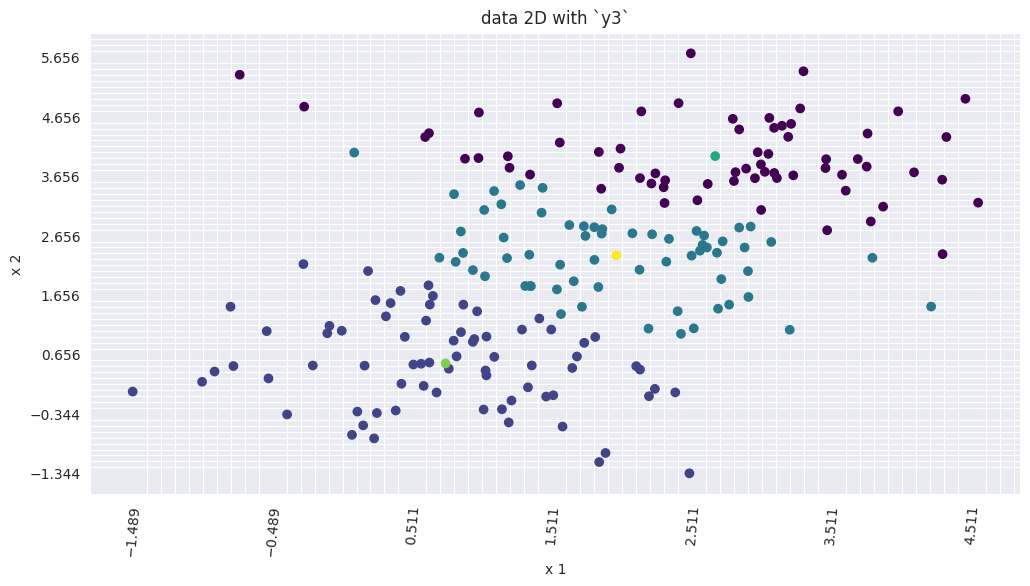

In [791]:
draw_2D_scatter(as_x=data_2d_c['x1'], as_y=data_2d_c['x2'], mark=data_2d_c['y3'], title=f'data 2D with `y3`', xlabel='x 1', ylabel=f'x 2', figsize=size)

## INTERPRET

In [792]:
kmeans[1].predict([[0, 0], [1.5, 1.7], [2.5, 3.6], [2.6, -0.35], [-0.5, 3], [3.5, 0], [0.5, 5]])

array([1, 1, 0, 1, 1, 1, 0], dtype=int32)

In [793]:
kmeans[2].predict([[0, 0], [1.5, 1.7], [2.5, 3.6], [2.6, -0.35], [-0.5, 3], [3.5, 0], [0.5, 5]])

array([1, 2, 0, 1, 2, 2, 0], dtype=int32)

# `mnist`

## SCRUB & EXPLORE

In [794]:
mnist.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## По аналогії з попереднім датасетом, якщо прийняти колонку 0 як відому приналежність до кластерів (0-9)

In [795]:
Y = mnist['x0']
df = mnist.drop('x0', axis=1)

Зменшимо розмірність за допомогою Principal Component Analysis та глянемо чи необхідна нормалізація
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

/tmp/ipykernel_4624/3806943738.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(as_x, as_y, c=mark, cmap='viridis')


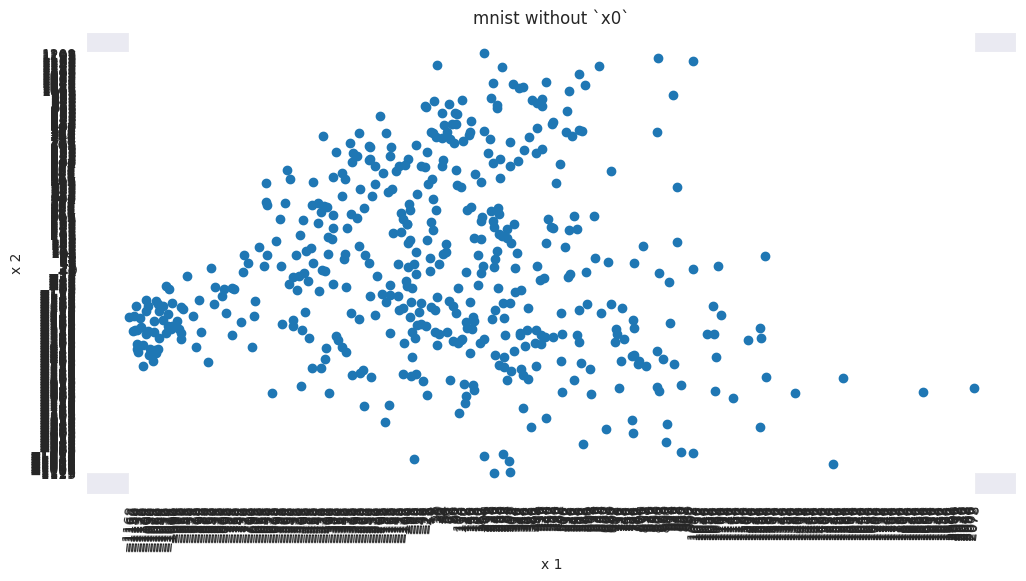

In [796]:
x_pca = PCA(n_components=2).fit_transform(df)
size = (12, 6)
draw_2D_scatter(as_x=x_pca[:, 0], as_y=x_pca[:, 1], mark=None, title=f'mnist without `x0`', xlabel='x 1', ylabel=f'x 2', figsize=size)

Як бачимо необхідна нормалізація

Нормалізуємо значення фіч

In [797]:
x_norm = StandardScaler().fit_transform(df)

Зменшимо розмірність за допомогою Principal Component Analysis
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [798]:
x_pca = PCA(n_components=2).fit_transform(x_norm)

/tmp/ipykernel_4624/3806943738.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(as_x, as_y, c=mark, cmap='viridis')


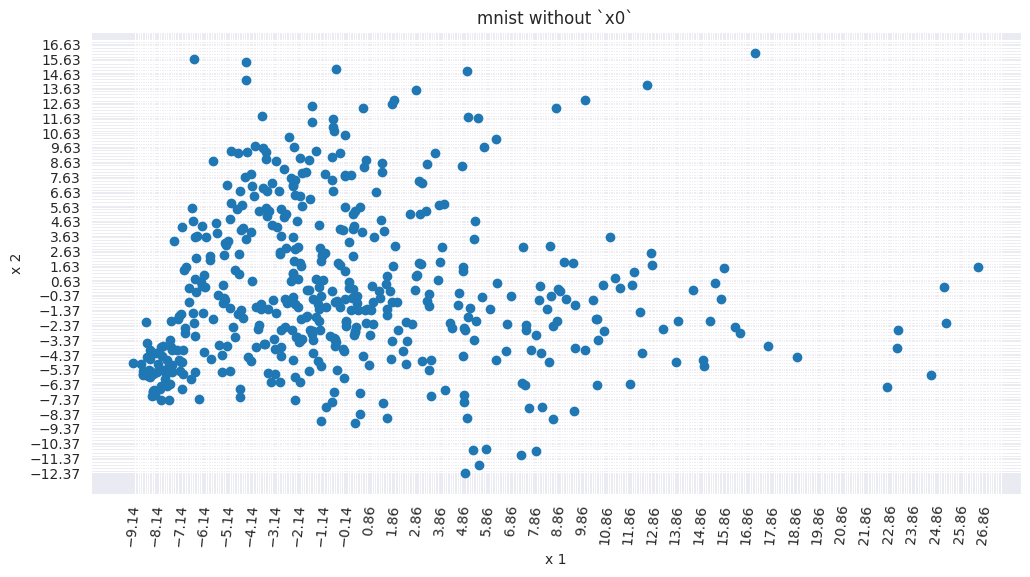

In [799]:
size = (12, 6)
draw_2D_scatter(as_x=x_pca[:, 0], as_y=x_pca[:, 1], mark=None, title=f'mnist without `x0`', xlabel='x 1', ylabel=f'x 2', figsize=size)

## MODEL

##### Розрахуємо для розбиття на кластери від 1 до 11

In [800]:
X = x_pca
x = [n_clus for n_clus in range(1, 12)]
kmeans = [KMeans(n_clusters=n_clus, random_state=0, n_init='auto').fit(X) for n_clus in x]
y = [km.inertia_ for km in kmeans]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


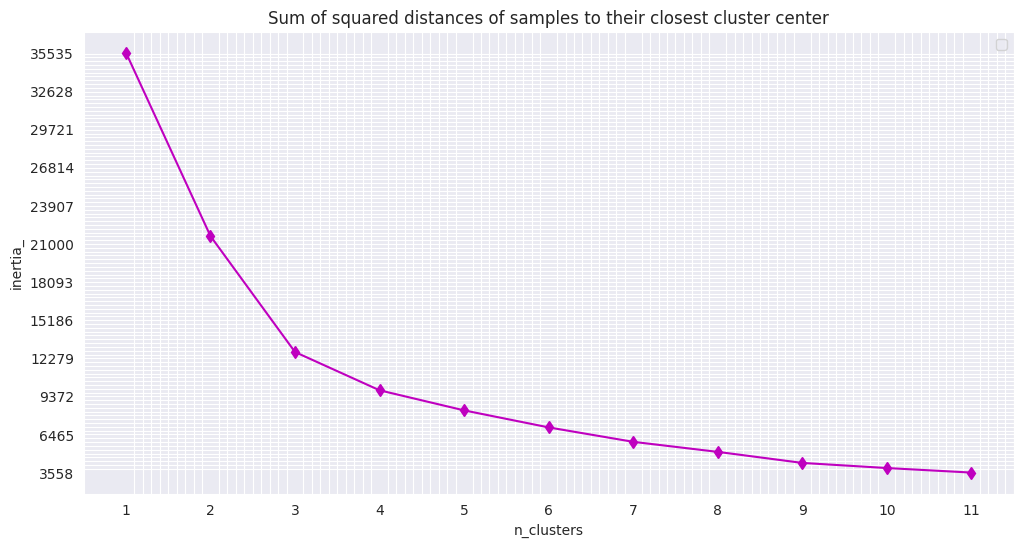

In [801]:
title = 'Sum of squared distances of samples to their closest cluster center'
draw_2D(as_x=x, as_y=y, title=title, xlabel='n_clusters', ylabel=f'inertia_', figsize=(12, 6))

Візуально начебто 3 кластери оптимально, але ...

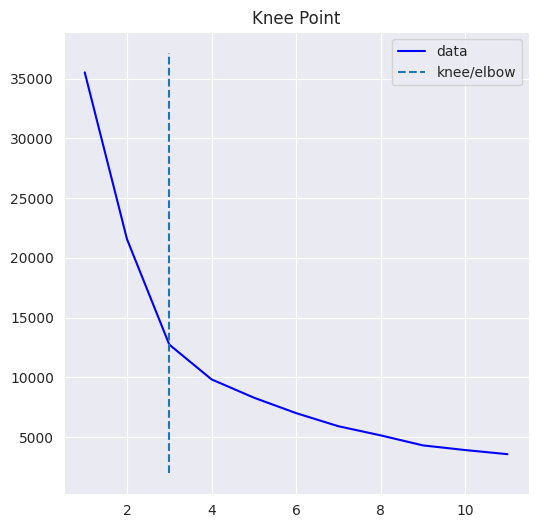

In [802]:
kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')
kneedle.plot_knee()

Теж 3 класи

In [803]:
kmeans[2].labels_

array([1, 0, 2, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 2, 2,
       1, 2, 1, 0, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2,
       0, 1, 2, 0, 1, 0, 0, 2, 2, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1,
       2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 2, 0,
       0, 1, 2, 2, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 1, 1, 2, 2,
       2, 2, 1, 1, 2, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 1, 0, 2, 2, 2,
       1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2,
       1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1,
       0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 1,
       2, 2, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2,
       2, 1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 0, 0, 2, 2,

In [804]:
kmeans[2].cluster_centers_

array([[ 9.83744053, -2.67794415],
       [-1.12974311,  6.45394898],
       [-3.53859476, -3.07432552]])

In [805]:
centroids = pd.DataFrame(kmeans[2].cluster_centers_)
centroids.columns = ['x1', 'x2']
centroids

,x1,x2
0,9.837441,-2.677944
1,-1.129743,6.453949
2,-3.538595,-3.074326


Додамо результат кластеризації - позначення `y3`

In [806]:
data_mnist = pd.DataFrame(x_pca)
data_mnist.columns = ['x1', 'x2']
y3 = pd.DataFrame({'y3':kmeans[2].labels_})
data_mnist_c = pd.concat([data_mnist, y3], axis=1)
data_mnist_c.head()

,x1,x2,y3
0,-4.478009,4.203529,1
1,4.914274,-12.365890,0
2,-6.994537,-5.628978,2
3,8.546157,-0.384590,0
4,1.144511,6.615649,1


Додамо центроїди

In [807]:
с3 = pd.DataFrame({'y3':[centroids.shape[0] + i for i in range(centroids.shape[0])], })
с3 = pd.concat([с3, centroids], axis=1)
data_mnist_c = pd.concat([data_mnist_c, с3], axis=0, ignore_index=True)
data_mnist_c.tail(6)

,x1,x2,y3
497,-6.210659,0.301431,2
498,0.342744,-0.363071,2
499,-4.819881,-3.176472,2
500,9.837441,-2.677944,3
501,-1.129743,6.453949,4
502,-3.538595,-3.074326,5


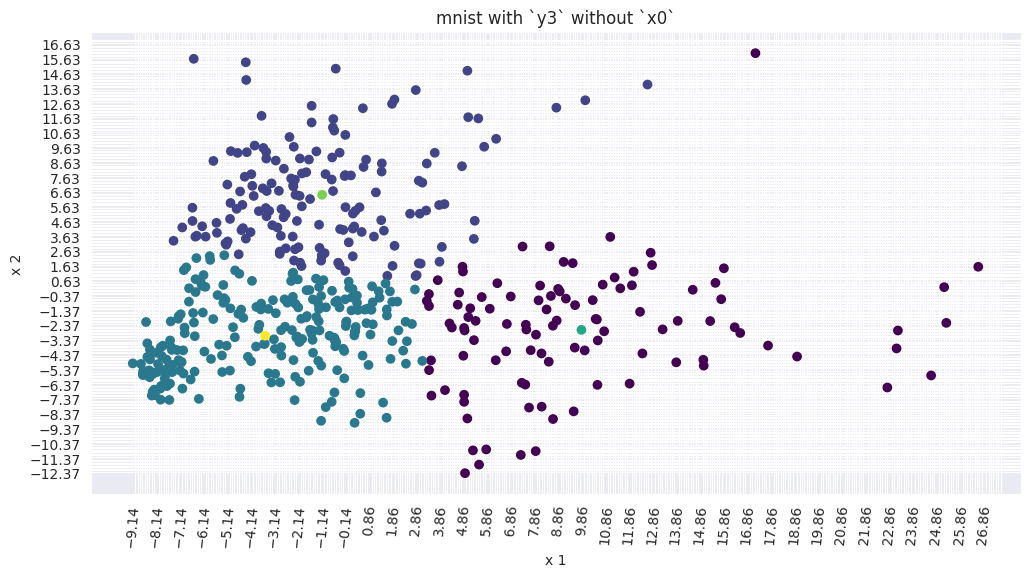

In [808]:
draw_2D_scatter(
                as_x=data_mnist_c['x1'], 
                as_y=data_mnist_c['x2'], 
                mark=data_mnist_c['y3'], 
                title=f'mnist with `y3` without `x0`', 
                xlabel='x 1', 
                ylabel=f'x 2', 
                figsize=size
                )

## INTERPRET

In [809]:
kmeans[2].predict([[2.86, -10], [-4, 2.13], [8, 8], [2.9, -0.4], [26, -10], [15, 17], [-10, 17], [-10, -10]])

array([2, 1, 1, 2, 0, 1, 1, 2], dtype=int32)

x0 як y (9 класів з першої колонки)

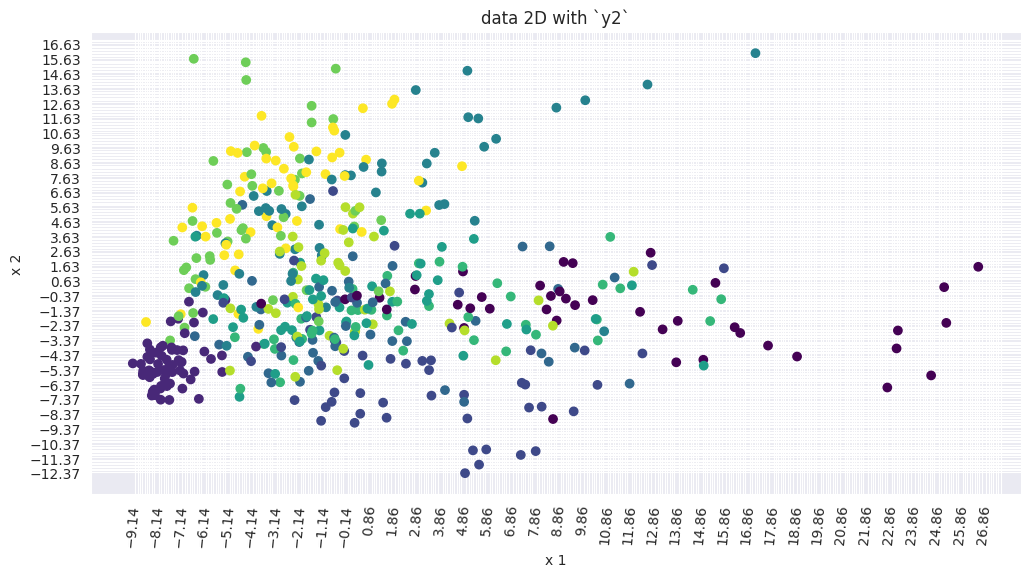

In [810]:
draw_2D_scatter(as_x=data_mnist['x1'], as_y=data_mnist['x2'], mark=Y.values, title=f'data 2D with `y2`', xlabel='x 1', ylabel=f'x 2', figsize=size)

 ## Якщо вважати дані з датасету підготовленими

Нормалізуємо значення фіч

In [811]:
x_norm = StandardScaler().fit_transform(mnist)

Зменшимо розмірність за допомогою Principal Component Analysis

In [812]:
x_pca = PCA(n_components=2).fit_transform(x_norm)

/tmp/ipykernel_4624/3806943738.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(as_x, as_y, c=mark, cmap='viridis')


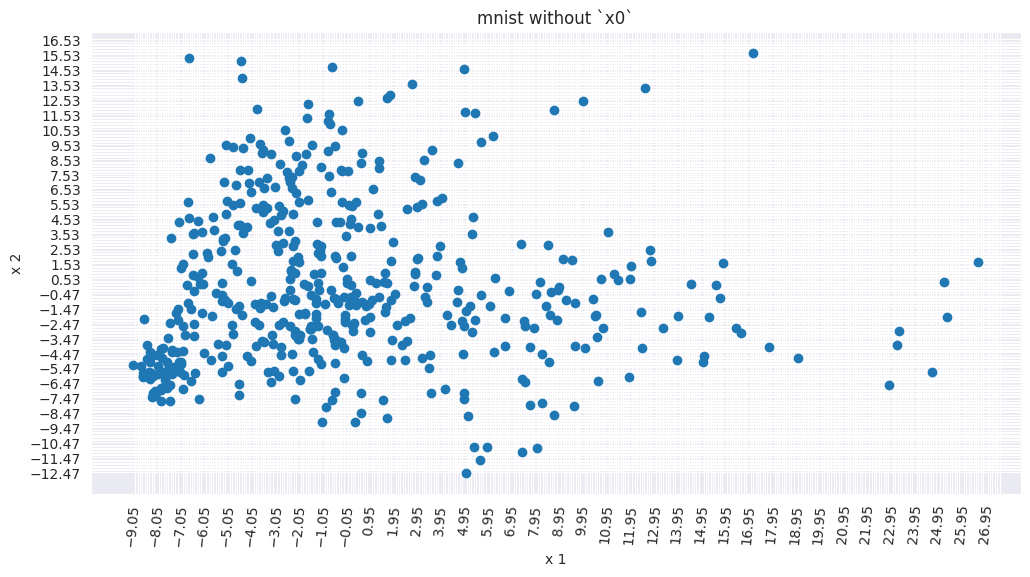

In [813]:
size = (12, 6)
draw_2D_scatter(as_x=x_pca[:, 0], as_y=x_pca[:, 1], mark=None, title=f'mnist without `x0`', xlabel='x 1', ylabel=f'x 2', figsize=size)

## MODEL

##### Розрахуємо для розбиття на кластери від 1 до 11

In [814]:
X = x_pca
x = [n_clus for n_clus in range(1, 12)]
kmeans = [KMeans(n_clusters=n_clus, random_state=0, n_init='auto').fit(X) for n_clus in x]
y = [km.inertia_ for km in kmeans]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


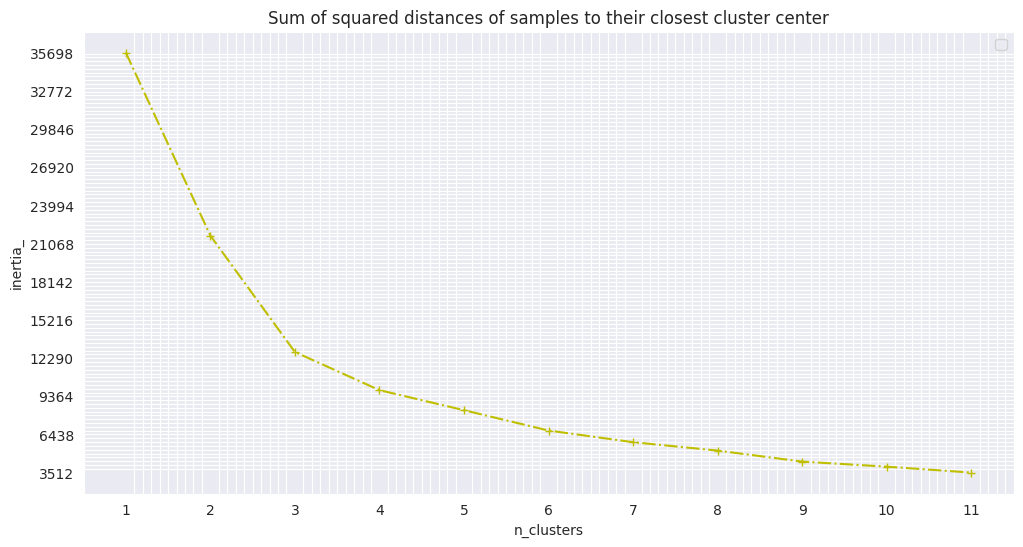

In [815]:
title = 'Sum of squared distances of samples to their closest cluster center'
draw_2D(as_x=x, as_y=y, title=title, xlabel='n_clusters', ylabel=f'inertia_', figsize=(12, 6))

Візуально начебто 3 кластери оптимально, але ...

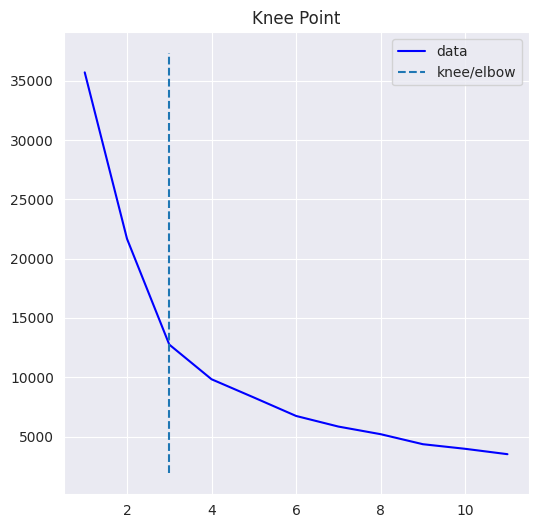

In [816]:
kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')
kneedle.plot_knee()

In [817]:
kmeans[2].labels_

array([2, 0, 1, 0, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 1, 0, 2, 2, 0, 2, 1, 1,
       2, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1,
       0, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 1, 1, 0,
       0, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 1, 2, 1, 2, 0, 0, 1, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 2, 2, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1,
       2, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1,
       2, 0, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2,
       0, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2,
       2, 1, 0, 1, 0, 0, 1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 0, 2, 1, 0, 2, 0, 0, 0, 1, 1,

In [818]:
kmeans[2].cluster_centers_

array([[ 9.86821735, -2.62525258],
       [-3.50083112, -3.14401768],
       [-1.22213163,  6.46393972]])

In [819]:
centroids = pd.DataFrame(kmeans[2].cluster_centers_)
centroids.columns = ['x1', 'x2']
centroids

,x1,x2
0,9.868217,-2.625253
1,-3.500831,-3.144018
2,-1.222132,6.463940


Додамо результат кластеризації - позначення `y3`

In [820]:
data_mnist = pd.DataFrame(x_pca)
data_mnist.columns = ['x1', 'x2']
y3 = pd.DataFrame({'y3':kmeans[2].labels_})
data_mnist_c = pd.concat([data_mnist, y3], axis=1)
data_mnist_c.head()

,x1,x2,y3
0,-4.528504,4.197385,2
1,5.025844,-12.470546,0
2,-6.907397,-5.890232,1
3,8.584212,-0.338957,0
4,1.105858,6.579164,2


Додамо центроїди

In [821]:
с3 = pd.DataFrame({'y3':[centroids.shape[0] + i for i in range(centroids.shape[0])], })
с3 = pd.concat([с3, centroids], axis=1)
data_mnist_c = pd.concat([data_mnist_c, с3], axis=0, ignore_index=True)
data_mnist_c.tail(6)

,x1,x2,y3
497,-6.208042,0.235743,1
498,0.380056,-0.372937,1
499,-4.814513,-3.144226,1
500,9.868217,-2.625253,3
501,-3.500831,-3.144018,4
502,-1.222132,6.463940,5


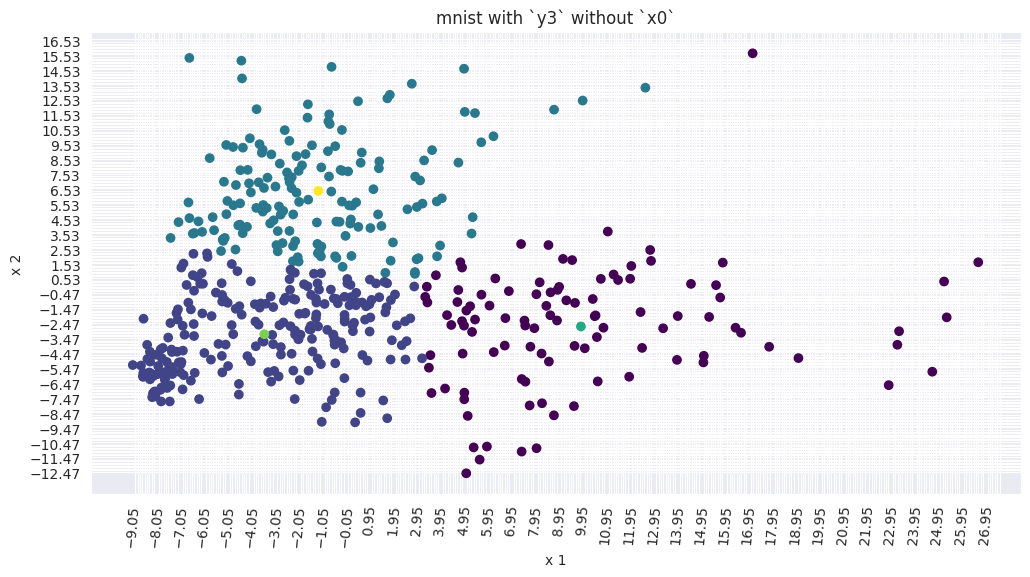

In [822]:
draw_2D_scatter(
                as_x=data_mnist_c['x1'], 
                as_y=data_mnist_c['x2'], 
                mark=data_mnist_c['y3'], 
                title=f'mnist with `y3` without `x0`', 
                xlabel='x 1', 
                ylabel=f'x 2', 
                figsize=size
                )

## INTERPRET

In [823]:
kmeans[2].predict([[2.86, -10], [-4, 2.13], [8, 8], [2.9, -0.4], [26, -10], [15, 17], [-10, 17], [-10, -10]])

array([1, 2, 2, 1, 0, 2, 2, 1], dtype=int32)

За першим датасетом (data_2d) виникла цікава розбіжність оптимального значення кількості кластерів між візуальним (на око) і алгоритмічним методом (реалізація - модуль knee). Візуально за результатами перевагу того чи іншого важко визначити, обидва варіанти досить непогано розділяють.
Можливо інші алгоритми для кластеризації показали б цікавіші результати, візуально можна виділити деякі значення схожі на аномальні, які можна було б виключити при розрахунку моделей (кластеризації), або зібрати більше різноманітних даних для виключення їх з аномальних.
У другому датасеті (mnist) занадто багато параметрів і занадто багато нулів ті й великий розкид деяких значень, що спонукає використовувати нормалізацію. Можливо навіть можна було б перевірити кореляційні зв'язки, якби було більше ненульових значень, і не обмежувати лише 2 параметрами методом PCA. Візуально також можна виділити явні аномалії, але це може свідчити про недостатній обсях зразків, а не лише про унікальність чи похибку отримання даних.